In [0]:
# Normalization will help our algorithm to train better. The networks are trying to learn how important and how weighty a certain pixel should be .
# to determine the class of the image. Normalizing the pixel values help these gradients calculations stay consistent and not let them get so large that 
# they slow down or prevent the network from training. in MLP, we do vector flattening .

In [0]:
# !pip install torch

In [0]:
# !pip install torchvision

In [0]:
import torch
import numpy as np

In [0]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [0]:
num_workers=0
# data you wanna load in parralael

batch_size=20
# batch_size IS THE NUMBER OF IMAGES that will be seen in one training iteration, where one training iteration means one time the network makes a mistake
# and learns from it using backpropagation.
transform=transforms.ToTensor()
# Tensor datatype is same as numpy but it can be loaded onto gpu for faster processing.

# percentage of training set to use as validation
valid_size = 0.2


In [0]:
# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
# Download the data and transfrom it into Tensor datat type whioch has been discussed earlier.Its downloaded to "data" directory.
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)


In [0]:

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


In [0]:
# WHY TRAINING , VALIDATION AND TEST DATASET?
# After every epoch of training we check how our model performs over our validation dataset and on that basis we decide if our model is
# going to overfit or not I.E  check how well the model generalizes . Test set is to know the accuracy of the model after it has been trained.
# Its gonna test the model on the data that it hasn't seen before.
# If we use only trai n and validation dataset it means the model is biased in favour of validation dataset .
# Even our model isn't updating weights based on validation dataset ,our model selction process is based on how it performs on both
# train and validation set . and so in the end its biased in favor of validation set.

In [0]:
# prepare data loaders
# These train and test loaders help us to iterate over our data one batch at a time.
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

In [0]:
# VISUALISE THE DATA

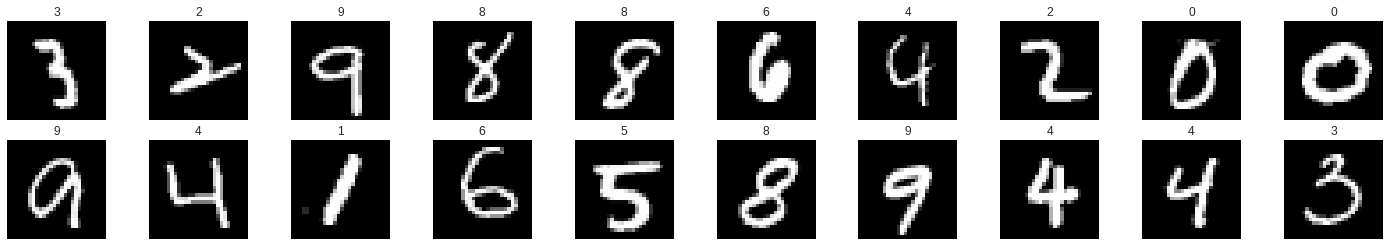

In [63]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
# Grabbing one batch of image and data and plotting 20 of them.
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

In [0]:
# Lets dig deep into an image and see how are the pixel values normalized.

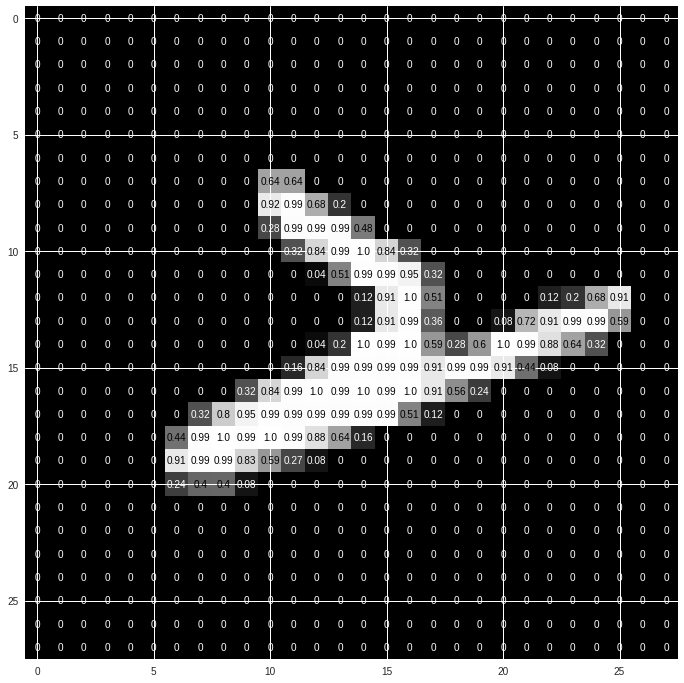

In [65]:
img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

In [0]:
# Define the network architecture

In [67]:
import torch.nn as nn
import torch.nn.functional as F
# Init function is used to name or define  the layers like fc1,fc2 and fc3
# define the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # number of hidden nodes in each layer (512)
        hidden_1 = 512
        hidden_2 = 512
        # linear layer (784 -> hidden_1)
        self.fc1 = nn.Linear(28 * 28, hidden_1)
        # linear layer (n_hidden -> hidden_2)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        # linear layer (n_hidden -> 10)
        self.fc3 = nn.Linear(hidden_2, 10)
        # dropout layer (p=0.2)
        # dropout prevents overfitting of data
        self.dropout = nn.Dropout(0.2)
# Feed forward function . This is how an input x is passed through various layers and will be transformed 
    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        # add dropout layer
        x = self.dropout(x)
        # add output layer
        x = self.fc3(x)
        return x

# initialize the NN
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)


In [0]:
# TRAINING THE NETWORK

In [0]:
# BEFORE WE TRAIN , SET THE LOSS FUNCTION AND THE OPTIMIZER.

In [0]:
# Cross entropy function is performing a softmax function on the output layer and then doing negative log loss. If our model produces only
# class scores , rest is sorted out , then this loss function will turn them into probability and calculate the loss.
# This loss is calculated as an  avg value  over a batch of images.

In [0]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [72]:
# number of epochs to train the model
n_epochs = 50
# Each epoch is one pass via the dataset.
# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
#   train_loader will load the batch of data and we will train our model by looking at each and every image input and label for that batch. 
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model , i.e a batch of data is passed 
        output = model(data)
        # calculate the cross entropy loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update) ,updating the values of weight in the network.
        optimizer.step()
        # update running training loss
#         loss.item() is loss value thats averaged over the batch . In this case we wanna accumulated loss over the batch not the average one.
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
#     No backpropagation over validation data
    model.eval() # prep model for evaluation
    for data, target in valid_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update running validation loss 
        valid_loss += loss.item()*data.size(0)
        
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss
        
# model.eval() will set all the layers in your model to evaluation mode. This affects layers like dropout layers that turn "off" nodes during 
# training with some probability, but should allow every node to be "on" for evaluation. So, you should set your 
# model to evaluation mode before testing or validating your model and set it to model.train() (training mode) only during the training loop.         

Epoch: 1 	Training Loss: 0.757442 	Validation Loss: 0.075865
Validation loss decreased (inf --> 0.075865).  Saving model ...
Epoch: 2 	Training Loss: 0.279943 	Validation Loss: 0.059642
Validation loss decreased (0.075865 --> 0.059642).  Saving model ...
Epoch: 3 	Training Loss: 0.223345 	Validation Loss: 0.049273
Validation loss decreased (0.059642 --> 0.049273).  Saving model ...
Epoch: 4 	Training Loss: 0.185192 	Validation Loss: 0.042184
Validation loss decreased (0.049273 --> 0.042184).  Saving model ...
Epoch: 5 	Training Loss: 0.157232 	Validation Loss: 0.037378
Validation loss decreased (0.042184 --> 0.037378).  Saving model ...
Epoch: 6 	Training Loss: 0.137255 	Validation Loss: 0.032972
Validation loss decreased (0.037378 --> 0.032972).  Saving model ...
Epoch: 7 	Training Loss: 0.119996 	Validation Loss: 0.029838
Validation loss decreased (0.032972 --> 0.029838).  Saving model ...
Epoch: 8 	Training Loss: 0.108239 	Validation Loss: 0.027905
Validation loss decreased (0.02983

In [0]:
# Load the Model with the Lowest Validation Loss

In [0]:
model.load_state_dict(torch.load('model.pt'))

In [0]:
# Test the Trained Network

In [0]:
# Check out One Solution

In [79]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for evaluation

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.059146

Test Accuracy of     0: 99% (972/980)
Test Accuracy of     1: 99% (1126/1135)
Test Accuracy of     2: 98% (1014/1032)
Test Accuracy of     3: 98% (991/1010)
Test Accuracy of     4: 97% (958/982)
Test Accuracy of     5: 97% (873/892)
Test Accuracy of     6: 98% (941/958)
Test Accuracy of     7: 97% (1004/1028)
Test Accuracy of     8: 97% (946/974)
Test Accuracy of     9: 97% (984/1009)

Test Accuracy (Overall): 98% (9809/10000)


In [80]:
pred

tensor([2, 6, 5, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6])

In [0]:
# PIPELINE

In [0]:
# 1 -LOAD AND VISUALIZE THE DATA.
# 2 -PRE-PROCESS I.E NORMALIZE THE DATA
# 3 -DEFINE A MODEL ARCHITECTURE.
# 4 -TRAIN YOUR MODEL
# 5 -SAVE THE BEST MODEL
# 6 -TEST YOUR MODEL ON UNSEEN DATA